# Importing Libiraries

In [2]:
!pip install segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import cv2
import glob
import tifffile as tiff
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from segmentation_models import Unet
from tensorflow.keras.metrics import Precision, Recall, BinaryIoU
from tensorflow.keras.optimizers import Adam

Segmentation Models: using `tf.keras` framework.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_path='/content/drive/MyDrive/computer_vision/satalite data/data/'
dataset_dir = os.listdir(data_path)
print(f'The Dataset directory constists of {dataset_dir} directories.')

The Dataset directory constists of ['images', 'labels'] directories.


In [6]:
import glob
images_dir = os.path.join(data_path, 'images')
masks_dir = os.path.join(data_path, 'labels')


In [7]:
image_paths = sorted(glob.glob(os.path.join(images_dir, "*.*")))
mask_paths = sorted(glob.glob(os.path.join(masks_dir, "*.*")))


In [8]:
print(f"Total Images: {len(image_paths)}")
print(f"Total Masks: {len(mask_paths)}")

Total Images: 306
Total Masks: 456


In [9]:
image_files = {os.path.splitext(f)[0] for f in os.listdir(images_dir)}
mask_files = {os.path.splitext(f)[0] for f in os.listdir(masks_dir)}

In [10]:
# Find common IDs to ensure 1:1 mapping
common_ids = sorted(list(image_files.intersection(mask_files)))

In [11]:
image_paths = [os.path.join(images_dir, f"{i}.tif") for i in common_ids]
mask_paths = [os.path.join(masks_dir, f"{i}.png") for i in common_ids]

print(f"Matched Pairs: {len(image_paths)}")

Matched Pairs: 306


In [12]:
# Create a DataFrame to synchronize paths
df = pd.DataFrame({
    'image_path': [os.path.join(images_dir, f"{i}.tif") for i in common_ids],
    'mask_path': [os.path.join(masks_dir, f"{i}.png") for i in common_ids]
})

print(f"Total matched samples: {len(df)}")
df.head()

Total matched samples: 306


,image_path,mask_path
0,/content/drive/MyDrive/computer_vision/satalit...,/content/drive/MyDrive/computer_vision/satalit...
1,/content/drive/MyDrive/computer_vision/satalit...,/content/drive/MyDrive/computer_vision/satalit...
2,/content/drive/MyDrive/computer_vision/satalit...,/content/drive/MyDrive/computer_vision/satalit...
3,/content/drive/MyDrive/computer_vision/satalit...,/content/drive/MyDrive/computer_vision/satalit...
4,/content/drive/MyDrive/computer_vision/satalit...,/content/drive/MyDrive/computer_vision/satalit...


# Data Visualization

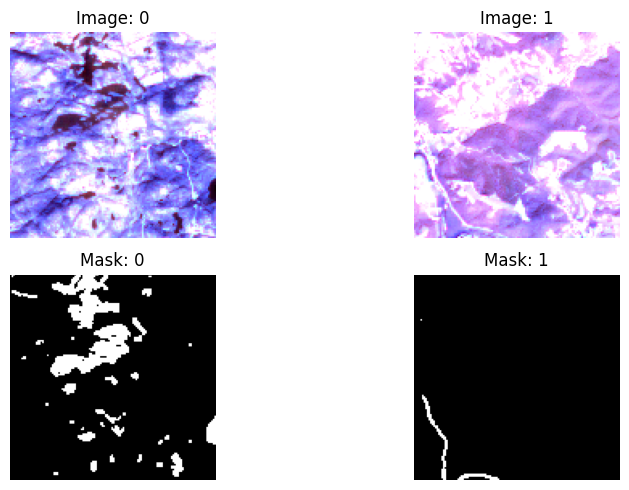

In [13]:

plt.figure(figsize=(10, 5))
for i in range(2):
    # Load Image (TIF)
    img_path = os.path.join(images_dir, common_ids[i] + ".tif")
    img = tiff.imread(img_path)
    # Use only first 3 channels for visualization
    display_img = img[:, :, :3] if img.ndim == 3 else img

    # Load Mask (PNG) - Using cv2 to avoid format errors
    mask_path = os.path.join(masks_dir, common_ids[i] + ".png")
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 2, i + 1)
    plt.imshow(display_img)
    plt.title(f"Image: {common_ids[i]}")
    plt.axis('off')

    plt.subplot(2, 2, i + 3)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask: {common_ids[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing

In [14]:
from sklearn.model_selection import train_test_split
SEED = 42
BATCH_SIZE = 16
IMG_SIZE = (128, 128)

train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)

In [15]:
def normalize_image(img):

    norm_img = np.zeros_like(img, dtype=np.float32)
    for b in range(img.shape[-1]):
        band_min = img[:, :, b].min()
        band_max = img[:, :, b].max()
        if band_max - band_min != 0:
            norm_img[:, :, b] = (img[:, :, b] - band_min) / (band_max - band_min + 1e-5)
        else:
            norm_img[:, :, b] = 0.0
    return norm_img

def load_data(image_path, mask_path):
    img = tiff.imread(image_path).astype('float32')
    img = cv2.resize(img, IMG_SIZE)

    img = normalize_image(img)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE).astype('float32')
    mask = cv2.resize(mask, IMG_SIZE)
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)

    return img, mask

def data_generator(dataframe, batch_size=16):
    while True:
        df_shuffled = dataframe.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df_shuffled), batch_size):
            batch_df = df_shuffled.iloc[i : i + batch_size]
            imgs, msks = [], []
            for _, row in batch_df.iterrows():
                img, msk = load_data(row['image_path'], row['mask_path'])
                imgs.append(img)
                msks.append(msk)
            yield np.array(imgs), np.array(msks)

train_gen = data_generator(train_df, batch_size=BATCH_SIZE)
test_gen = data_generator(test_df, batch_size=BATCH_SIZE)

#  UnetModel

In [24]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
def UNet_from_Scratch():
    # Input Layer
    inputs = Input((128, 128, 12))

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model


In [26]:
model_scratch = UNet_from_Scratch()

model_scratch.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', BinaryIoU(name='iou')]
)

In [27]:
BATCH_SIZE = 16
steps_per_epoch = len(train_df)
validation_steps = len(test_df)

history_scratch = model_scratch.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=test_gen,
    validation_steps=validation_steps,
    verbose=1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 103s 4s/step - accuracy: 0.5326 - iou: 0.3579 - loss: 0.6713 - val_accuracy: 0.7738 - val_iou: 1.0000 - val_loss: 0.1983
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.7505 - iou: 1.0000 - loss: 0.1784 - val_accuracy: 0.7460 - val_iou: 1.0000 - val_loss: 0.1522
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - accuracy: 0.7183 - iou: 1.0000 - loss: 0.1493 - val_accuracy: 0.7607 - val_iou: 1.0000 - val_loss: 0.1295
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.7133 - iou: 1.0000 - loss: 0.1265 - val_accuracy: 0.7714 - val_iou: 1.0000 - val_loss: 0.1116
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.7112 - iou: 1.0000 - loss: 0.1101 - val_accuracy: 0.7780 - val_iou: 1.0000 - val_loss: 0.0984
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.7155 - iou: 1.0000 - loss: 0.0974 - val_accuracy: 0.7638 - val_iou: 1.0000 - val_loss: 0.0878
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 